In [5]:
cd /home

/home


# Astromer I vs Astromer II

In [6]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from glob import glob
import toml
import os

from sklearn.metrics import r2_score, mean_squared_error
from presentation.experiments.utils import get_clf_summary
from src.utils import get_metrics

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**WARNING**: This notebook was made to visualize classification results only. 

All the following blocks assume you already ran the script `./presentation/experiments/astromer_{1/2}/script.py`.

The directory looks like: 
- `presentation`
    - `astromer_1/results/<experiment_folder>`
        - `finetuning`
        - `classification`
        - `pretraining`
    - `astromer_2/results/<experiment_folder>`
        - `finetuning`
        - `classification`
        - `pretraining`

In [8]:
folders = [
    './presentation/experiments/astromer_0/results/',
     './presentation/experiments/astromer_1/results/',
    './presentation/experiments/astromer_2/results/'
]
tags = ['50\% Probed', '20\% Probed']

In [9]:
all_folders = []
for f in folders:
    all_folders+=glob(os.path.join(f, '*', '*'))
del all_folders[-3]
all_folders

['./presentation/experiments/astromer_0/results/bugstromer_clean/2023-10-19_18-40-56',
 './presentation/experiments/astromer_0/results/bugstromer/2023-10-16_14-06-03',
 './presentation/experiments/astromer_0/results/bugstromer_clean_2/2023-11-02_20-36-11',
 './presentation/experiments/astromer_1/results/astromer_1_clean/2023-10-30_20-19-16',
 './presentation/experiments/astromer_1/results/astromer_1_clean/2023-10-24_13-37-08',
 './presentation/experiments/astromer_1/results/astromer_1_clean/2023-10-30_13-10-32',
 './presentation/experiments/astromer_1/results/astromer_1_clean/2023-10-23_15-36-27',
 './presentation/experiments/astromer_1/results/bugstromer_nc_2/2023-10-21_23-06-54',
 './presentation/experiments/astromer_1/results/astromer_1_clean_2/2023-11-02_20-33-24',
 './presentation/experiments/astromer_1/results/astromer_1/2023-10-23_12-09-49',
 './presentation/experiments/astromer_1/results/astromer_1/2023-10-21_23-07-40',
 './presentation/experiments/astromer_2/results/astromer_2

# Pretraining

In [10]:
rows = []
for f in all_folders:
    rmse_val = get_metrics(os.path.join(f, 'pretraining', 'logs', 'validation'), show_keys=False, metric_name='rmse')
    r2_val   = get_metrics(os.path.join(f, 'pretraining', 'logs', 'validation'), show_keys=False, metric_name='r_square')
            
    with open(os.path.join(f, 'pretraining', 'config.toml'), 'r') as handle:
        conf = toml.load(handle)
    conf['rmse'] = rmse_val['value'].min()
    conf['r2'] = r2_val['value'].max()
    try:
        r2_test = get_metrics(os.path.join(f, 'pretraining', 'logs', 'test'), show_keys=False, metric_name='r_square')
        conf['state'] = 'finished' 
    except:
        conf['state'] = 'running'
    conf['path'] = f.split('results/')[-1]
    rows.append(conf)

In [11]:
df = pd.DataFrame(rows)
filtered = df[['exp_name', 'probed', 'dropout', 'r2', 'rmse', 'scheduler', 'state', 'path']].sort_values('r2', ascending=False)
filtered.fillna('1e-3')

,exp_name,probed,dropout,r2,rmse,scheduler,state,path
3,astromer_1_clean,0.0,0.0,0.99995977,0.0012162522,False,finished,astromer_1_clean/2023-10-30_20-19-16
8,astromer_1_clean_2,0.2,0.0,0.8346174,0.0638941,False,finished,astromer_1_clean_2/2023-11-02_20-33-24
4,astromer_1_clean,0.2,0.0,0.8330377,0.06412041,False,finished,astromer_1_clean/2023-10-24_13-37-08
7,bugstromer_nc_2,0.5,0.0,0.8049141,0.14583479,True,running,bugstromer_nc_2/2023-10-21_23-06-54
11,astromer_2_clean,0.2,0.0,0.8035775,0.06838322,1e-3,finished,astromer_2_clean/2023-11-02_20-32-34
1,bugstromer,0.5,0.0,0.8009453,0.14739424,True,finished,bugstromer/2023-10-16_14-06-03
0,bugstromer_clean,0.5,0.0,0.7928149,0.07134047,True,finished,bugstromer_clean/2023-10-19_18-40-56
2,bugstromer_clean_2,0.5,0.0,0.77139676,0.07492458,False,running,bugstromer_clean_2/2023-11-02_20-36-11
9,astromer_1,0.5,0.0,0.77123815,0.15804788,True,finished,astromer_1/2023-10-23_12-09-49
6,astromer_1_clean,0.2,0.0,0.73340315,0.08080528,True,finished,astromer_1_clean/2023-10-23_15-36-27


Text(0, 0.5, 'R-square')

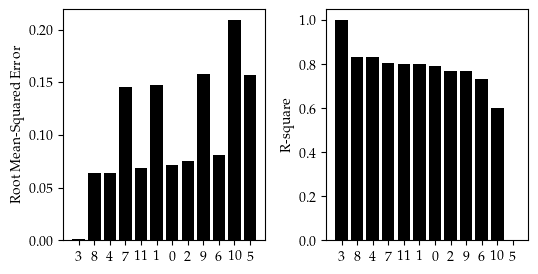

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=100, gridspec_kw={'wspace':.3})
x = filtered.index
axes[0].bar([str(xx) for xx in x], filtered.rmse, color='k')
axes[1].bar([str(xx) for xx in x], filtered.r2, color='k')

axes[0].set_ylabel('Root Mean-Squared Error')
axes[1].set_ylabel('R-square')

# Classification

In [13]:
'./presentation/experiments/astromer_1/results/astromer_1/2023-10-21_23-07-40/'

'./presentation/experiments/astromer_1/results/astromer_1/2023-10-21_23-07-40/'

In [72]:
rows = []
for f in all_folders:
    with open(os.path.join(f, 'pretraining', 'config.toml'), 'r') as handle:
        conf = toml.load(handle)
    for ds in ['alcock', 'atlas']:
        for ns in [20, 100]:
            for fold_n in range(3):
                for ft_name in ['', '_ft_allvisible', '_finetuning']:
                    for clf_name in ['cls_mlp', 'att_mlp', 'all_mlp']:
                        try:
                            clf_path = os.path.join(f, 
                                                    'classification'+ft_name, 
                                                    ds, 
                                                    'fold_{}'.format(fold_n), 
                                                    '{}_{}'.format(ds, ns),
                                                    'att_mlp',
                                                    'metrics.toml') 
                            with open(clf_path, 'r') as handle:
                                metrics = toml.load(handle)
                                for key in metrics.keys():
                                    metrics[key] = float(metrics[key])
                                metrics['dataset'] = ds
                                metrics['spc'] = ns
                                metrics['path'] = f.split('results/')[-1]
                                metrics['fold'] = fold_n
                                metrics['clf'] = clf_name
                                metrics['ft_name'] = 'allvisible' if ft_name == '_ft_allvisible' else 'masked'

                                rows.append(metrics)
                        except Exception as e:
                            continue
clf_summary = pd.DataFrame(rows)

In [73]:
particular = clf_summary.query('path.str.contains("astromer_2")', engine='python')
particular[['dataset', 'spc', 'clf', 'path', 'clf_test_f1']].groupby(['dataset', 'spc', 'clf', 'path']).mean()

clf_test_f1
dataset spc clf     path                                             
alcock  20  all_mlp astromer_2_clean/2023-11-02_20-32-34     0.285133
            att_mlp astromer_2_clean/2023-11-02_20-32-34     0.285133
            cls_mlp astromer_2_clean/2023-11-02_20-32-34     0.285133
        100 all_mlp astromer_2_clean/2023-11-02_20-32-34     0.435539
            att_mlp astromer_2_clean/2023-11-02_20-32-34     0.435539
            cls_mlp astromer_2_clean/2023-11-02_20-32-34     0.435539
atlas   20  all_mlp astromer_2_clean/2023-11-02_20-32-34     0.442397
            att_mlp astromer_2_clean/2023-11-02_20-32-34     0.442397
            cls_mlp astromer_2_clean/2023-11-02_20-32-34     0.442397
        100 all_mlp astromer_2_clean/2023-11-02_20-32-34     0.498685
            att_mlp astromer_2_clean/2023-11-02_20-32-34     0.498685
            cls_mlp astromer_2_clean/2023-11-02_20-32-34     0.498685

In [74]:
df_summary = clf_summary.groupby(['spc', 'dataset', 'clf', 'path', 'ft_name']).mean().reset_index()
df_summary_std = clf_summary.groupby(['spc', 'dataset', 'clf', 'path', 'ft_name']).std().reset_index()
df_summary_std = df_summary_std.rename(columns={'clf_val_acc':'std_val_acc', 
                                           'clf_val_loss':'std_val_loss',
                                           'clf_test_precision':'std_test_precision',
                                           'clf_test_recall':'std_test_recall',
                                           'clf_test_f1':'std_test_f1',
                                           'clf_test_acc':'std_test_acc'})
clf_summary = pd.merge(df_summary, df_summary_std, on=['spc', 'dataset', 'clf', 'path', 'ft_name'], how='right')

In [75]:
result = pd.merge(filtered, clf_summary, on="path", how="right")
result = result.fillna(False)
result['label'] = result.apply(lambda x: '{}_{}_{}_{}\n {}'.format(x['exp_name'],
                                         x['probed'],
                                         x['dropout'],
                                         'sch' if x['scheduler'] else '1e-3',
                                         x['ft_name']), axis=1)

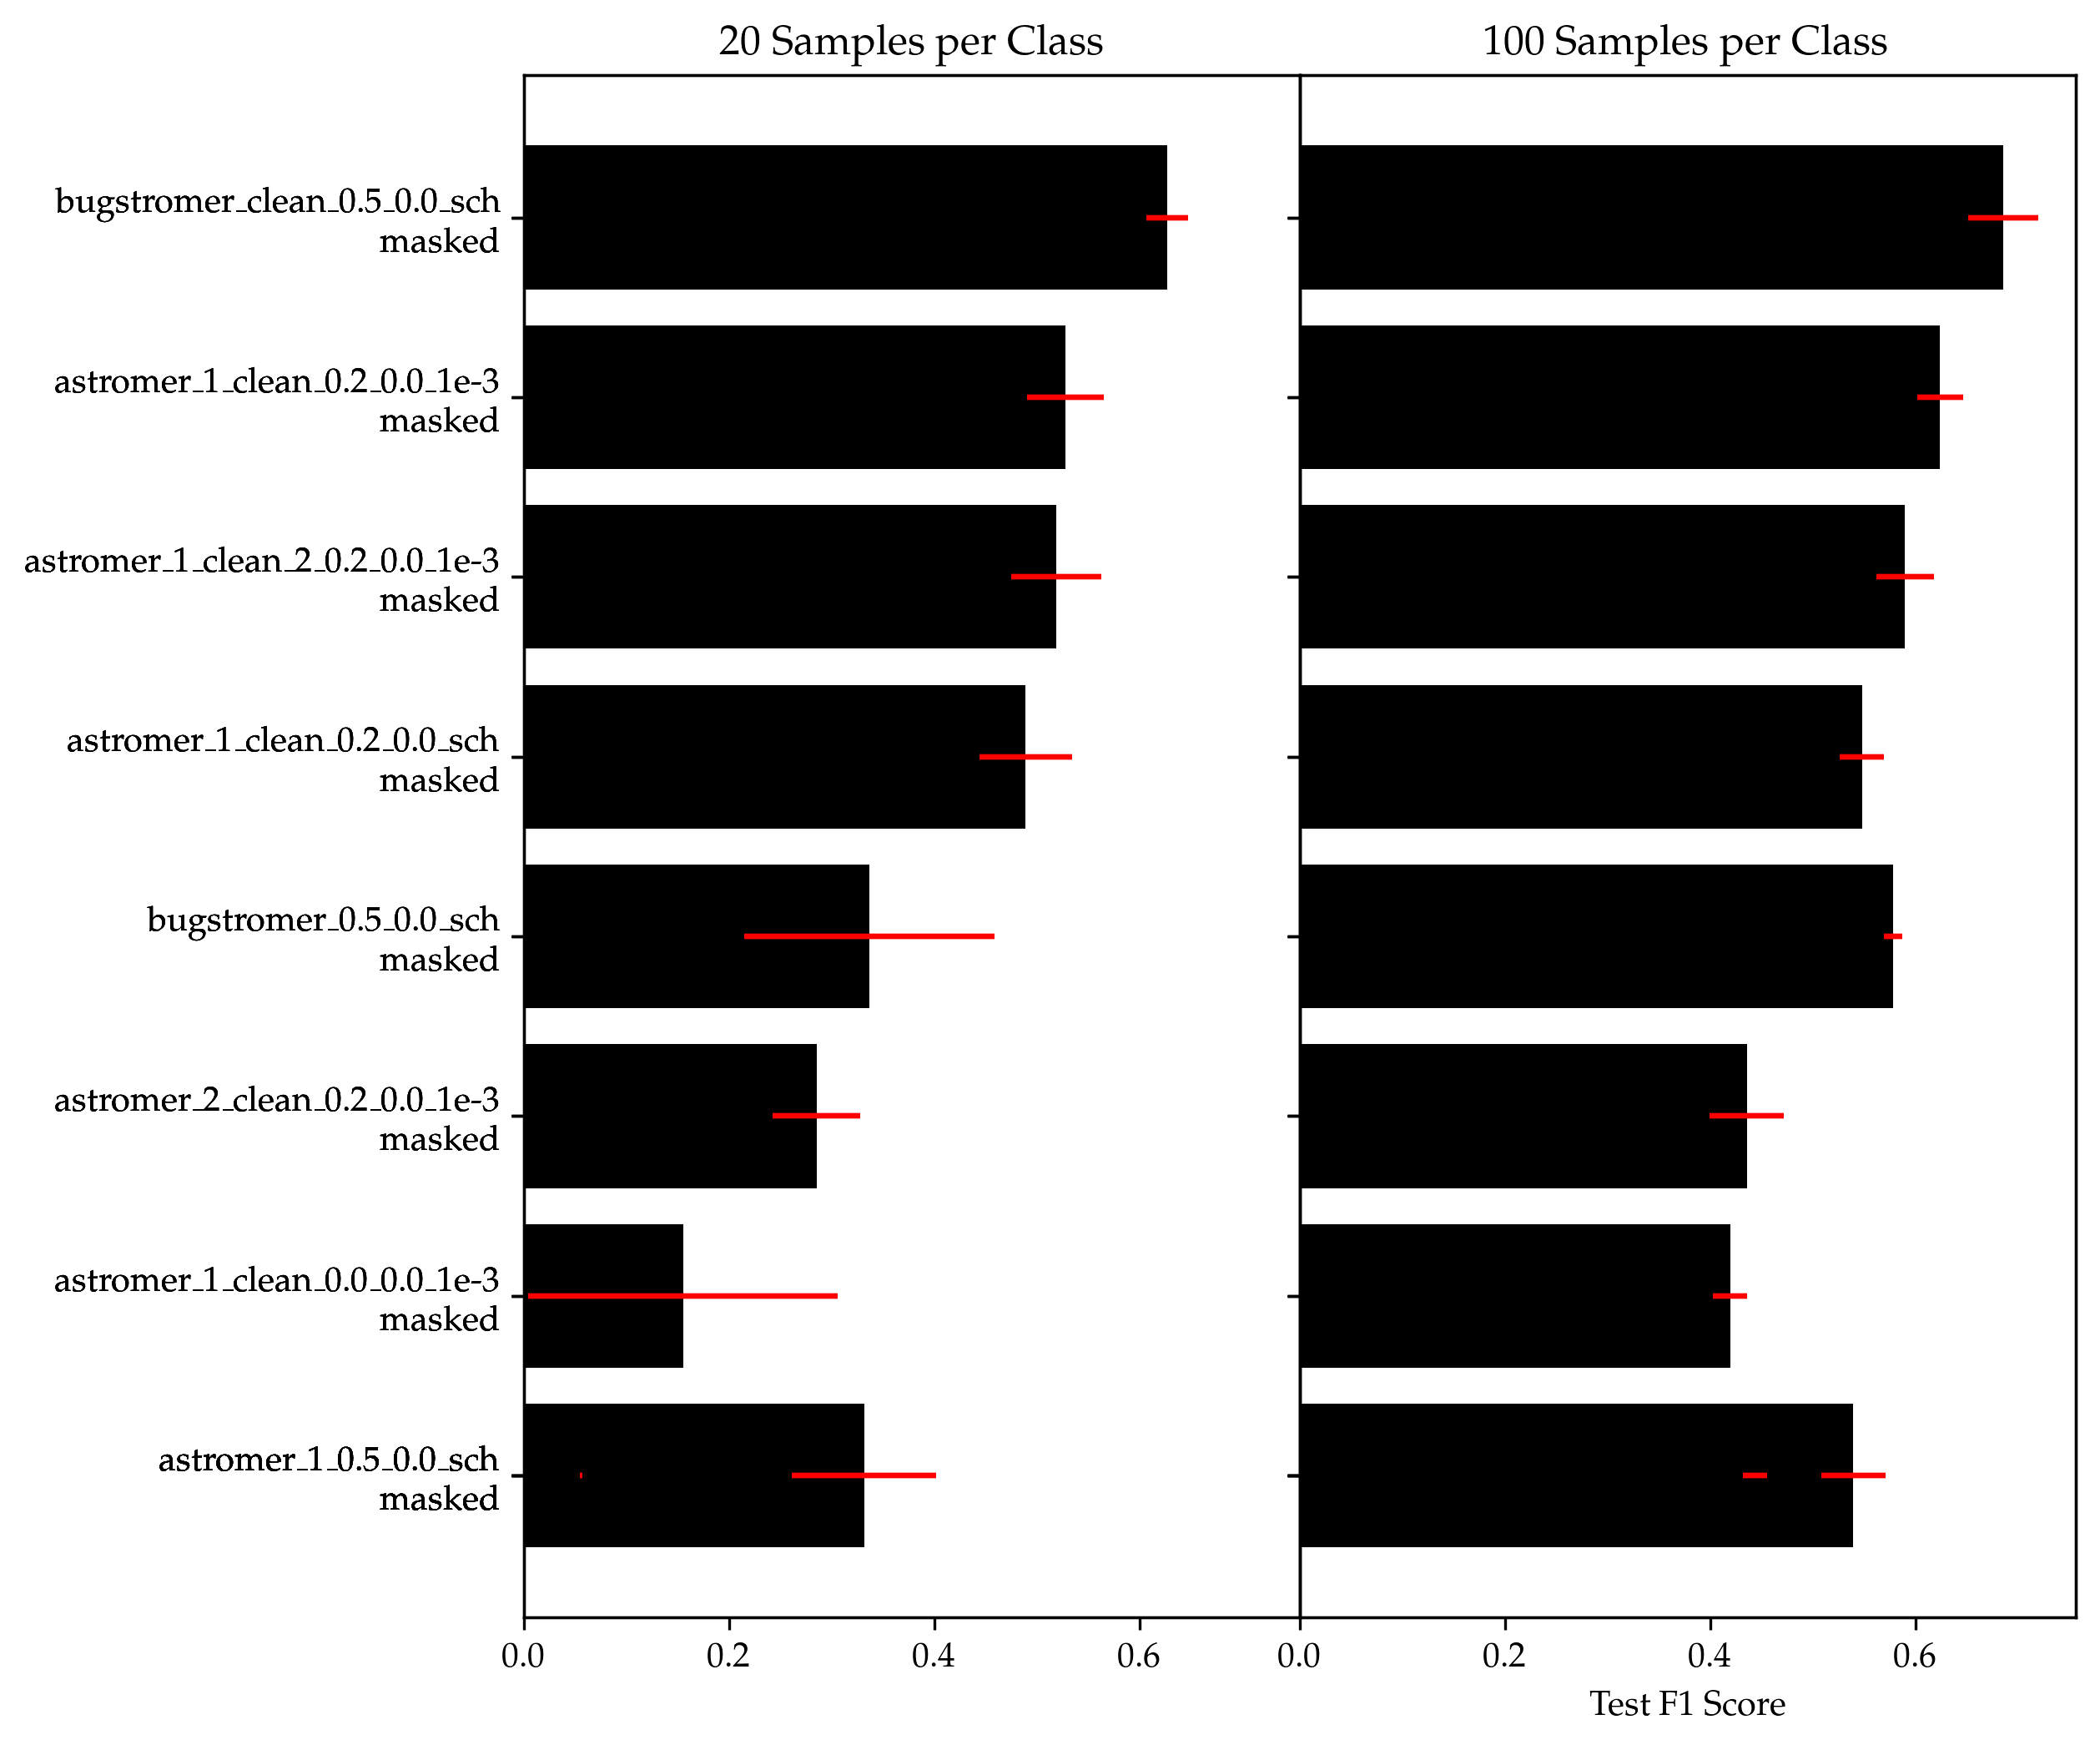

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(8, 8), sharex=True, dpi=300, sharey=True, gridspec_kw={'wspace':0.0})

# axes[0].set_title('Alcock')
axes[-1].set_xlabel('Test F1 Score')
for k, spc in enumerate([20, 100]):
    cond = result[(result['dataset'] == 'alcock') & (result['spc']==spc)]
    cond = cond.sort_values('clf_test_f1')
    y = cond['clf_test_f1']
    y_err = cond['std_test_f1']
    x = cond['label']
    
    axes[k].barh(x, y, xerr=y_err, color='k', error_kw={'ecolor':'red'})
    axes[k].set_yticks(x)
    ax2 = axes[k].twinx()
    ax2.set_yticks([])
    ax2.set_title('{} Samples per Class'.format(spc))

    ax2.yaxis.tick_right()

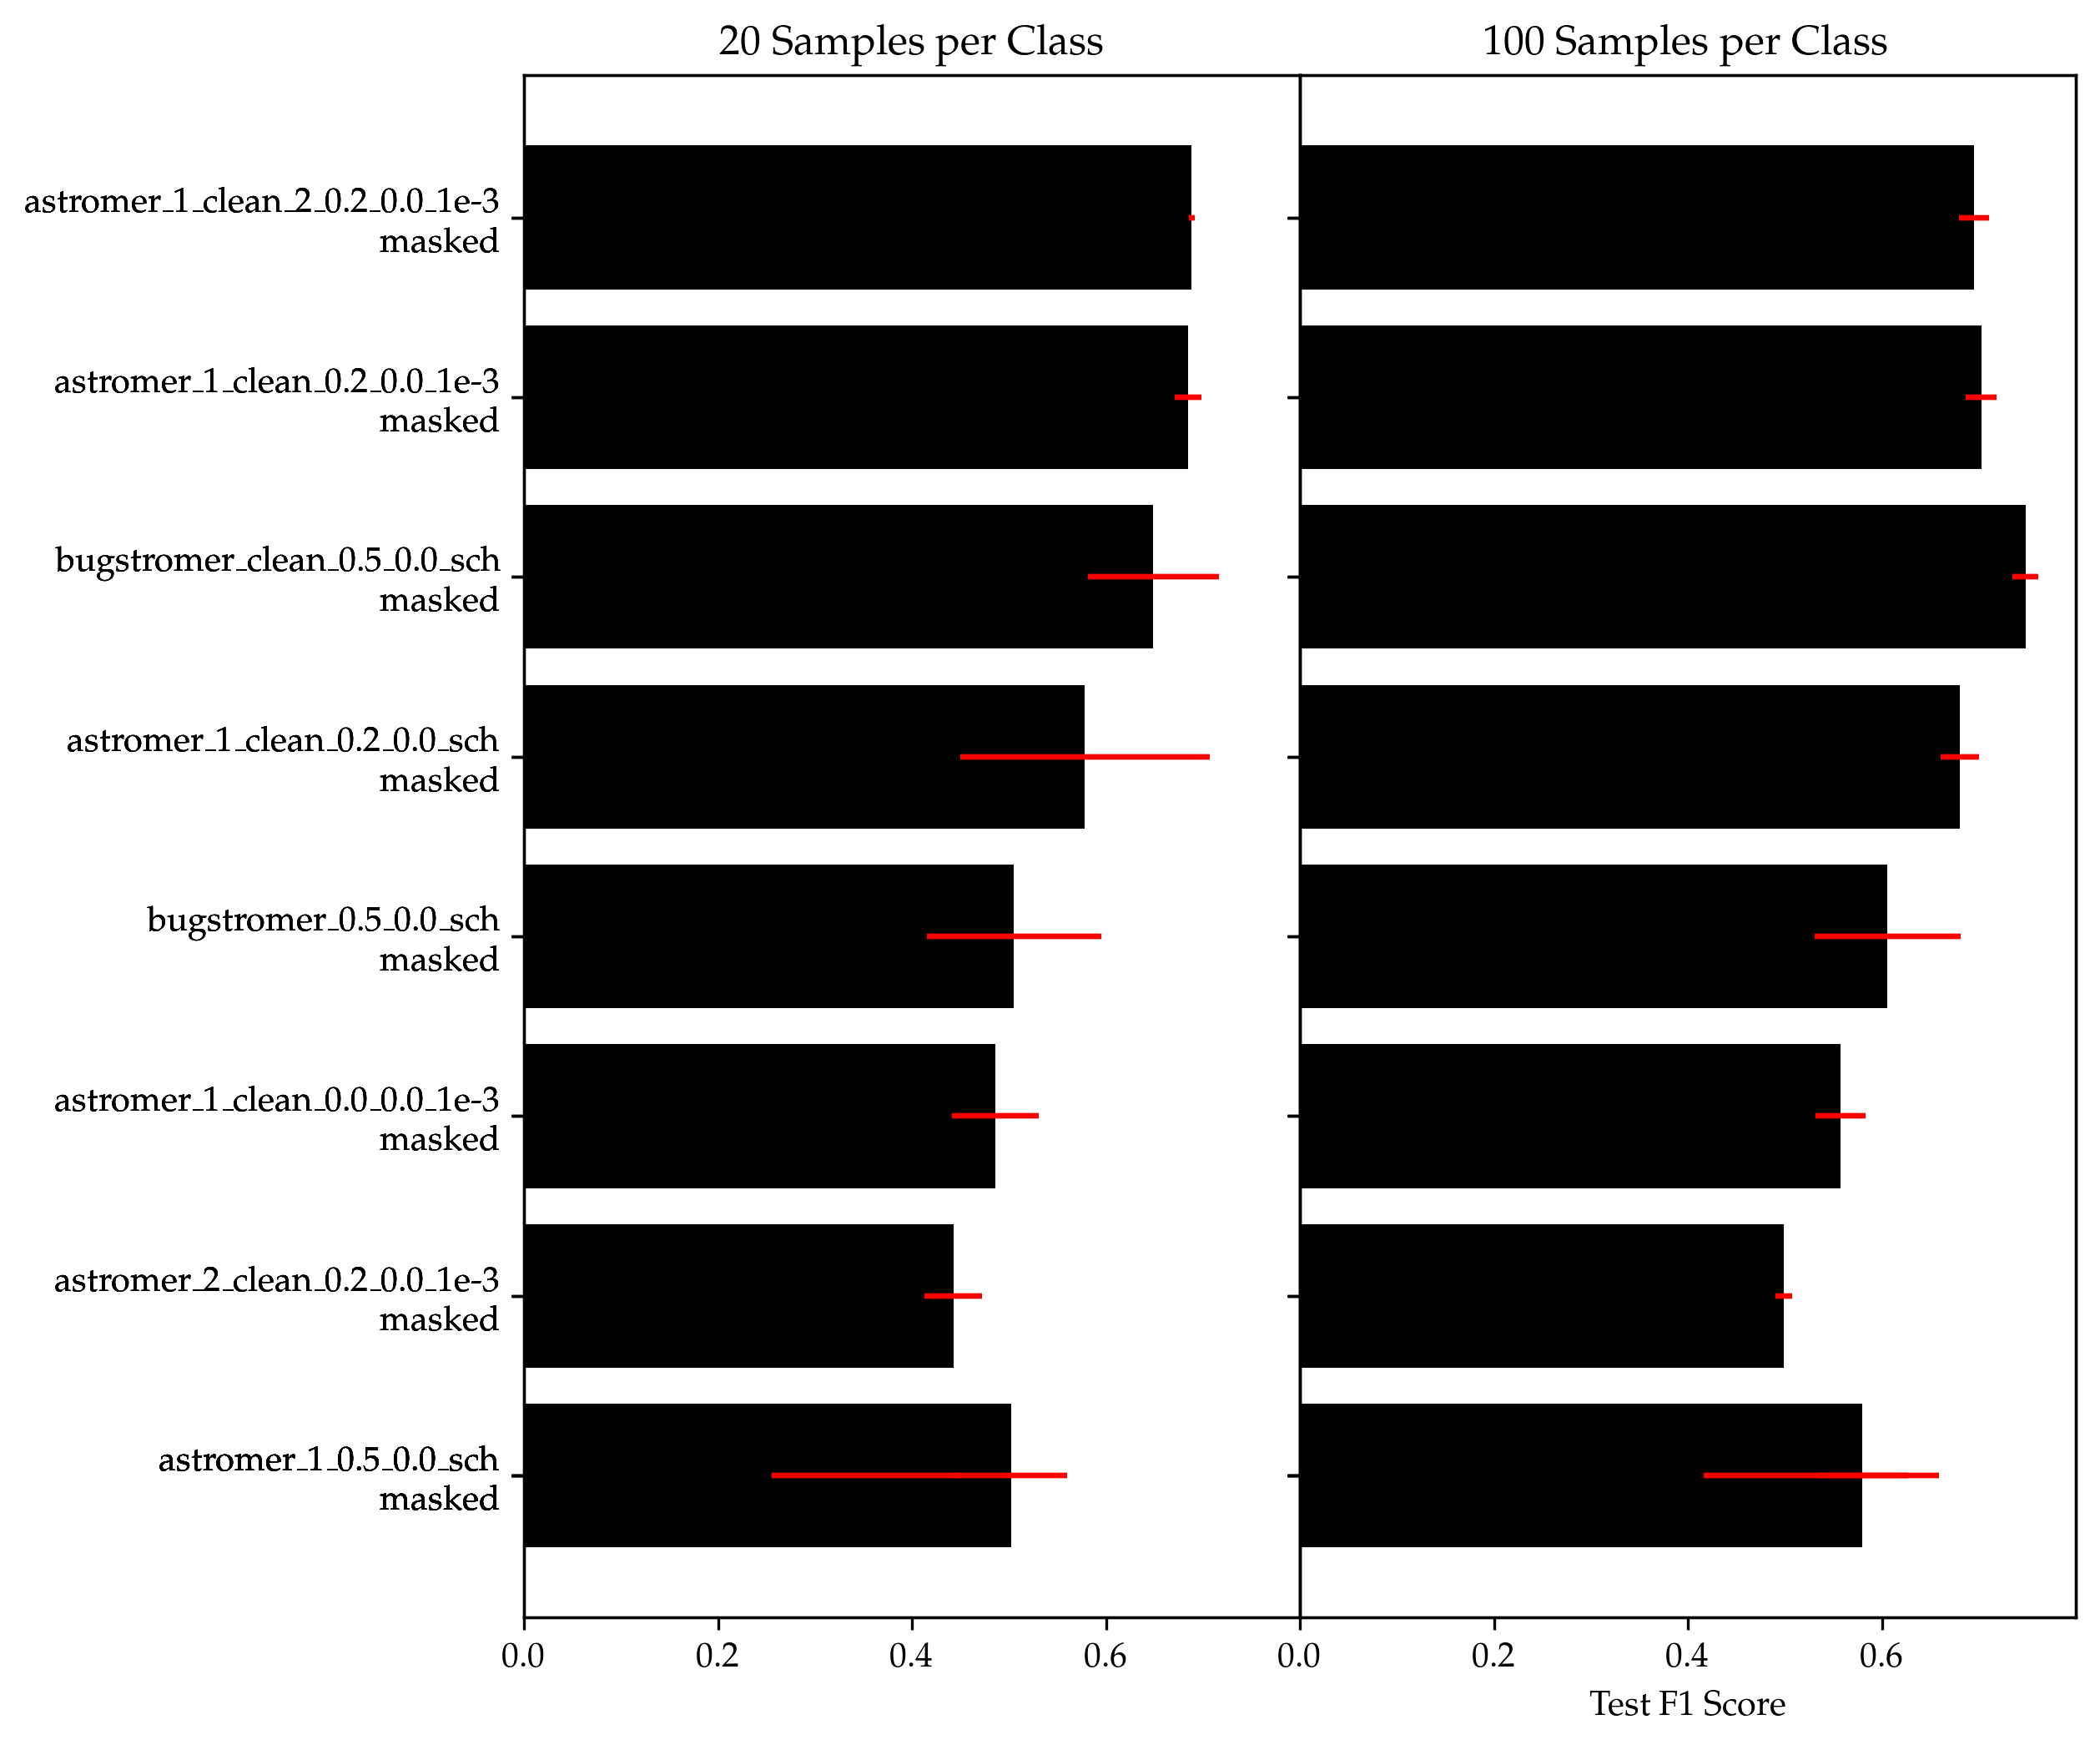

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(8, 8), sharex=True, dpi=300, sharey=True, gridspec_kw={'wspace':0.0})
# axes[0].set_title('Atlas')
axes[-1].set_xlabel('Test F1 Score')
for k, spc in enumerate([20, 100]):
    cond = result[(result['dataset'] == 'atlas') & (result['spc']==spc)]
    cond = cond.sort_values('clf_test_f1')
    y = cond['clf_test_f1']
    y_err = cond['std_test_f1']
    x = cond['label']
    
    axes[k].barh(x, y, xerr=y_err, color='k', error_kw={'ecolor':'red'})
    axes[k].set_yticks(x)
    ax2 = axes[k].twinx()
    ax2.set_yticks([])
    ax2.set_title('{} Samples per Class'.format(spc))

    ax2.yaxis.tick_right()

In [55]:
columns_to_compare = ['clf_test_f1', 'rmse', 'r2']
# valid = result[result['spc']==100]
valid = valid[columns_to_compare].dropna().astype(float)

# valid

In [56]:
import seaborn as sns

valid.shape

(26, 3)

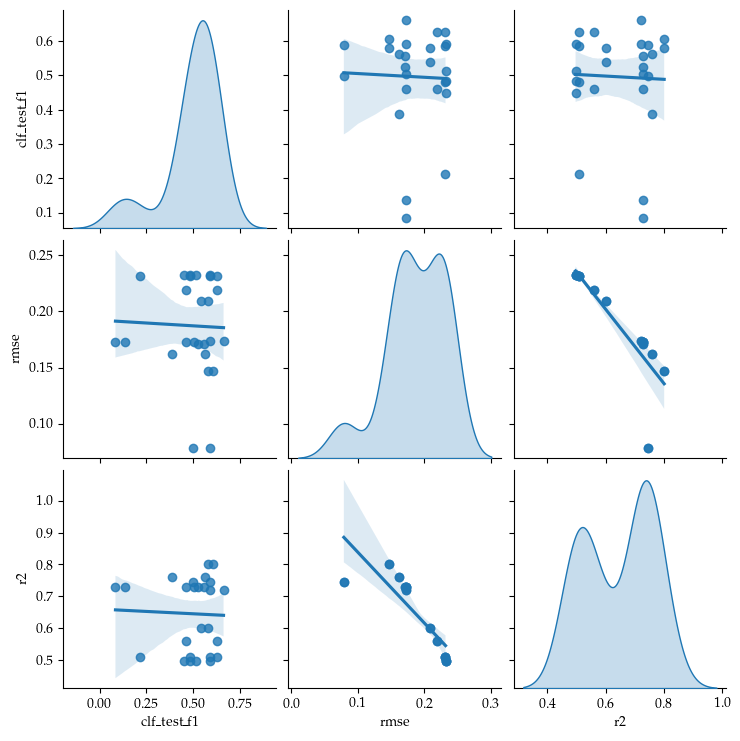

In [57]:
sns.pairplot(valid, vars=columns_to_compare, kind='reg', diag_kind='kde')